# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

We first need to import the dataset from the drive. You can change the path if the zip file is not at this location.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Mounted at /content/drive
Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
   creating: dataset/scenes/
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/models/
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  inflating: __MACOSX/dataset/scenes/._scene6.png  
  inflating: dataset/scenes/scene7.png  
  inflating: __MACOSX/dataset/scenes/._scene7.png  
  inflating: 

We then load all the libraries needed for the project.

In [2]:
import os # for the file.
import cv2 # for the detection.
import matplotlib.pyplot as plt # for the image visualisation.
import numpy as np # for the operations on the images.

We then create a function to split the images in two categories : one for each track. The function load_and_split_images will return images_first_part (1-5 for the scenes images and 1-14 for the models images), images_second_part (6-12 for the scenes images and 15-27 for the models images).

In [3]:
def load_and_split_images(folder, split_point, color_mode=cv2.IMREAD_COLOR):
    images_first_part = []
    images_second_part = []

    # Loop through each file in the folder, sorted alphabetically
    for filename in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, filename)  # Construct the full image path

        # Check if the file is a PNG image
        if img_path.endswith(".png"):
            img = cv2.imread(img_path, color_mode)  # Load the image using OpenCV

            # Check if the image was successfully loaded
            if img is not None:
                # Extract the number from the filename (remove 'ref' and 'scene', then convert to integer)
                number = int(filename.split('.')[0].replace('ref', '').replace('scene', ''))

                # Compare the number with the split point to decide which list to append to
                if number <= split_point:
                    images_first_part.append(img)  # Add to the first part list
                else:
                    images_second_part.append(img)  # Add to the second part list
            else:
                print(f"Failed to load image at {img_path}")  # Print an error message if the image fails to load

    return images_first_part, images_second_part  # Return the two lists of images


# **Track A - Single Instance Detection**

Before making any detections, we observed that the scene images have a lot of noise, which makes detection harder. We tried three types of filtering: median, bilateral, and Gaussian. The best result was obtained with median filtering. We apply this filtering before converting to grayscale because it gives better results. At the end of the function, we convert the scene images to grayscale.

Moreover, the best kernel size was 5. With either lower or higher values, the detection was less accurate and struggled more, even if we adjusted the hyperparameters.

In [4]:
def apply_median_filter(images, kernel_size=5):
    filtered_images = []
    for img in images:
        filtered_img = cv2.medianBlur(img, kernel_size)
        filtered_images.append(cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY))  # Convert to grayscale
    return filtered_images

Our approach involves using a SIFT detector on the scene images, pre-filtered by a median filter (as explained above)(inspired from the one of the practical session). A while loop iterates through each product, selecting the one with the maximum matching points. Once a product is detected, homography is applied. The loop stops if the number of matching points is too low (inferior to 25) or if any angle is either above 120 degrees or below 60 degrees, indicating the homography does not match the rectangular shape of the products.

If these two conditions are not met, the loop continues. To ensure we detect a genuine product and not a false positive, we added one final constraint. If all angles are not between 85 and 95 degrees, we discard the detected product and apply a black mask to the image. This implies that although a product was detected, it does not match any from our database, as the angles are outside the 85 to 95 degrees range.

A black mask is then applied to the image to prevent distortion in the calculation of matching points for subsequent detections. Conversely, if all angles are within the 85 to 95 degrees range, a black mask is still applied to ensure these points are excluded from the next wave of detections.

This function is used for the angles calcuation. This will be used in our two angles constraints describe above.

In [5]:
# Calculate the angle in degrees between vectors 'v1' and 'v2'
def angle_between_vectors(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0)
    return np.degrees(np.arccos(dot_product))

Finally, here is the function for the SIFT descriptor incorporating all the specificities mentioned earlier. For the line good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance], we used a threshold of 0.7 because a lower threshold did not yield enough points for scene 4, while a higher threshold caused the detection to retrieve points from other products.

In [6]:
def detect_and_mask_products(scene_image, model_images):
    # Create a SIFT detector object
    sift = cv2.SIFT_create()

    # Set parameters for the FLANN-based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    detections = []
    masked_image = scene_image.copy()
    scene_height, scene_width = scene_image.shape[:2]

    while True:
        # Detect keypoints and compute descriptors for the scene image
        scene_keypoints, scene_descriptors = sift.detectAndCompute(masked_image, None)
        max_matches = 0
        best_match = None
        best_model_keypoints = None
        best_homography = None

        # Iterate through each model image to find the best match
        for model_idx, model in enumerate(model_images):
            model_keypoints, model_descriptors = sift.detectAndCompute(model, None)
            matches = flann.knnMatch(model_descriptors, scene_descriptors, k=2)
            good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

            # Check if the current model has more good matches than previous best
            if len(good_matches) > max_matches:
                max_matches = len(good_matches)
                best_match = model_idx
                best_model_keypoints = model_keypoints

                if len(good_matches) > 10:
                    src_pts = np.float32([model_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    dst_pts = np.float32([scene_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                    best_homography = homography

        # Stop if the number of matches is below a threshold
        if max_matches < 25:
            break

        if best_homography is not None:
            # Calculate coordinates of model in the scene and mask it
            h, w = model_images[best_match].shape[:2]

            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, best_homography)

            # Calculate angles between consecutive corners
            angles = []
            num_corners = len(dst)
            for i in range(num_corners):
                v1 = dst[i][0] - dst[i - 1][0]
                v2 = dst[(i + 1) % num_corners][0] - dst[i][0]
                angle = angle_between_vectors(v1, v2)
                angles.append(angle)

            # Print angles and number of matches
            print(angles)
            print(max_matches)

            # Stop if any angle is less than 60 degrees or greater than 120 degrees
            if any(60 > angle or angle > 120 for angle in angles):
                break

            # Skip detection if angles are not close to 90 degrees
            if not all(85 <= angle <= 95 for angle in angles):
                # Mask the detected area for processing but don't add to detections
                cv2.fillConvexPoly(masked_image, dst.astype(int), 0)
                continue

            position = tuple(np.int32(dst[0, 0]))
            width = int(np.linalg.norm(dst[0][0] - dst[1][0]))
            height = int(np.linalg.norm(dst[0][0] - dst[3][0]))

            detection_details = (best_match, max_matches, position, width, height, dst)
            detections.append(detection_details)

            # Mask the detected area
            cv2.fillConvexPoly(masked_image, dst.astype(int), 0)

    return masked_image, detections

Now, we just need a function to draw green boxes around the detected products.

In [7]:
def draw_detections_on_image(image, detections, model_images):
    for detection in detections:
        best_match, max_matches, position, width, height, dst = detection
        color = (0, 255, 0)  # Green color for the rectangle
        cv2.polylines(image, [np.int32(dst)], True, color, 3)
        label = f'Product {best_match+1}'
        cv2.putText(image, label, position, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    return image

Execution part: First, we load the images (scenes and products), then filter them. We apply the SIFT detector to each scene in a loop, and finally, add the green boxes to the original images.

[89.92047264018252, 90.04827472221837, 90.0278514748146, 90.00340115406419]
680
[89.79888039800518, 90.03431884449076, 90.03010051832483, 90.13670024277135]
540
Product 1 {match: 680, position: (11, 15), width: 1047px, height: 800px}
Product 7 {match: 540, position: (847, 10), width: 1046px, height: 801px}


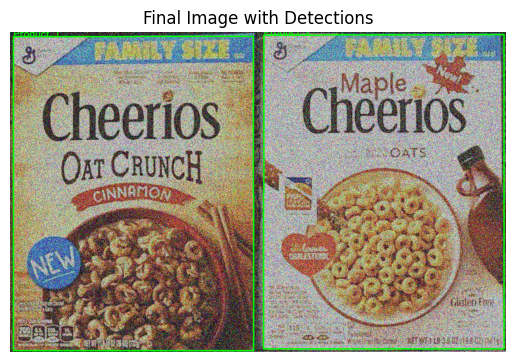

[89.92955738653765, 90.03086902810705, 90.00322509118043, 90.03634849828767]
315
[90.08731082219947, 90.19386605808393, 89.85695437251636, 89.86186876178081]
297
[90.24518236806055, 90.21219549280718, 89.67811667757898, 89.86450546244141]
253
[99.19285697020884, 24.87993633230875, 172.03094635016873, 113.65617036282116]
32
Product 10 {match: 315, position: (1248, 28), width: 843px, height: 560px}
Product 8 {match: 297, position: (3, 22), width: 942px, height: 603px}
Product 9 {match: 253, position: (610, 7), width: 951px, height: 633px}


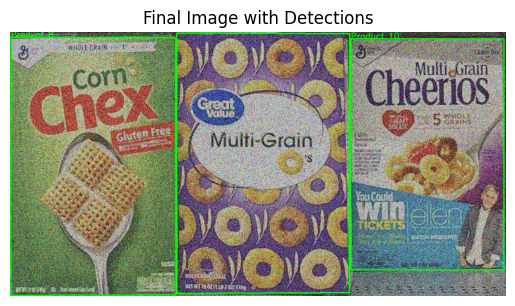

[89.9707792188293, 90.43283763362057, 89.41348909687942, 90.18289406025423]
160
[89.68095338488995, 90.09274914025823, 89.6091793080186, 90.61711813592655]
139
[90.18420857158992, 90.07520261882972, 89.78127661445576, 89.95931217282828]
98
Product 13 {match: 160, position: (1167, 9), width: 779px, height: 558px}
Product 11 {match: 139, position: (-2, 125), width: 668px, height: 604px}
Product 12 {match: 98, position: (616, 135), width: 650px, height: 543px}


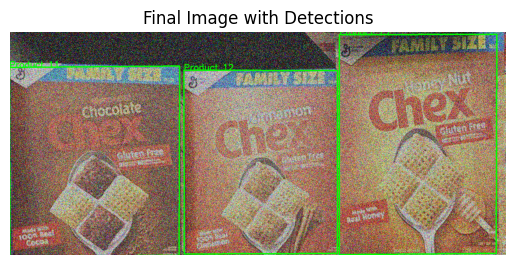

[89.17627263479618, 90.02735965778159, 90.20897543707024, 90.58739225721311]
232
[89.90630576441495, 90.02334795011454, 90.01121743519002, 90.05912885141856]
70
[89.26749102893083, 89.74380435339681, 90.50816526591484, 90.48053932382368]
52
[87.12188611740561, 86.91248389249455, 94.69052098646422, 91.27510947213152]
31
[93.42067243838684, 90.26195627637034, 88.96279033081817, 87.3545808429973]
27
[72.92987561039696, 75.69722121317785, 125.61242982783698, 85.76047729822096]
25
Product 1 {match: 232, position: (696, 664), width: 506px, height: 374px}
Product 14 {match: 70, position: (10, 711), width: 462px, height: 328px}
Product 13 {match: 52, position: (176, 15), width: 483px, height: 347px}
Product 2 {match: 31, position: (810, 100), width: 386px, height: 265px}
Product 12 {match: 27, position: (-188, 76), width: 427px, height: 359px}


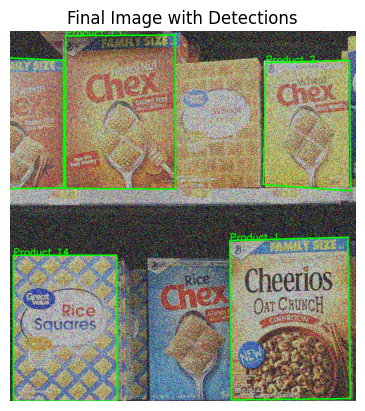

[89.91610146140965, 89.9247242700687, 90.09454132692736, 90.064632933225]
174
[87.47620020527934, 88.8978752490714, 90.94948500184579, 92.67643903792182]
82
[96.87864079322064, 88.06562713301899, 87.24376255978272, 87.8119695110268]
58
[175.89525189445993, 3.9397973971329483, 169.75152900215406, 18.293008630009396]
41
Product 3 {match: 174, position: (185, 475), width: 552px, height: 367px}
Product 4 {match: 82, position: (501, 424), width: 632px, height: 434px}


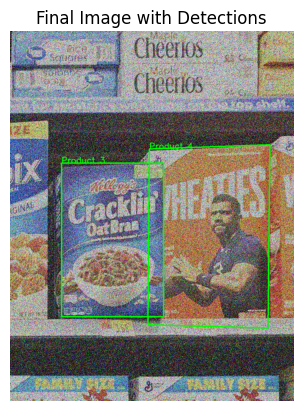

In [8]:
# Setup paths
scenes_folder = '/content/dataset/scenes'
models_folder = '/content/dataset/models'

# Load and separate images
model_images_first_part, _ = load_and_split_images(models_folder, 14)
scene_images_first_part, _ = load_and_split_images(scenes_folder, 5, cv2.IMREAD_COLOR)

# Apply median filter and convert to grayscale
filtered_scene_images = apply_median_filter(scene_images_first_part, kernel_size=5)

# Detect products and mask them iteratively
for scene_image, original_image in zip(filtered_scene_images, scene_images_first_part):
    result_image, product_detections = detect_and_mask_products(scene_image, model_images_first_part)
    final_image = draw_detections_on_image(original_image, product_detections, model_images_first_part)
    for detection in product_detections:
        best_match, max_matches, position, width, height, dst = detection
        print(f"Product {best_match + 1} {{match: {max_matches}, position: {position}, width: {width}px, height: {height}px}}")

    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))  # Display the final image with detections
    plt.title('Final Image with Detections')
    plt.axis('off')
    plt.show()

Additional details :     
Product 12 in scene 4 may sometimes not be detected because it is partially cut off, resulting in fewer matching points.